In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    
    return stemmed_tokens

[nltk_data] Downloading package punkt to /Users/freeman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/freeman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 33.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [7]:
import numpy as np
from gensim.models import Word2Vec

In [8]:
import csv
text = []
glove_embeddings = {}
with open('ml_data/cnne.csv') as csvfile:
     spamreader = csv.reader(csvfile)
     for row in spamreader:
        text.append(row[7].split())
         

In [4]:
flat_list = [item for sublist in text[1:] for item in sublist]

In [5]:
text = ' '.join(flat_list)
preprocessed_tokens = preprocess_text(text)

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [9]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

In [12]:
import spacy

nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    persons = set()
    locations = set()
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            persons.add(ent.text)
        elif ent.label_ == 'GPE':  # Geo-Political Entity
            locations.add(ent.text)
    return persons, locations


In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_embedding(word):
    return glove_embeddings.get(word.lower(), None)

def find_top_related(person, persons, locations, top_n=15):
    person_vec = get_embedding(person)
    if person_vec is None:
        return []
    
    related_entities = []
    for entity in persons.union(locations):
        entity_vec = get_embedding(entity)
        if entity_vec is not None:
            similarity = cosine_similarity([person_vec], [entity_vec])[0][0]
            related_entities.append((entity, similarity))
    
    related_entities.sort(key=lambda x: x[1], reverse=True)
    return related_entities[:top_n]


In [17]:
from sklearn.manifold import TSNE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(selected_person, related_entities):
    # Prepare labels for visualization: the selected person and the related entities (names or locations)
    labels = [selected_person] + [entity for entity, _ in related_entities]
    
    # Assuming 'get_embedding' function retrieves the GloVe embedding for a given entity
    embeddings = np.array([get_embedding(selected_person)] + [get_embedding(entity) for entity, _ in related_entities])
    
    # Initialize and fit t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    # Visualization
    plt.figure(figsize=(10, 10))
    for i, label in enumerate(labels):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y)
        plt.annotate(label, (x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

# Define 'get_embedding' to retrieve embeddings; this is placeholder and needs to be defined based on your embeddings
def get_embedding(entity_name):
    # Assuming 'glove_embeddings' is a dictionary of word embeddings
    return glove_embeddings.get(entity_name, np.zeros((100,)))  # Return zero vector if entity not found

# Assuming 'selected_person' is the name of the person you're interested in
# And 'related_entities' is a list of tuples where each tuple is (entity_name, similarity_score)
# Here you need to replace these variables with actual data based on your analysis
selected_person = 'ExamplePerson'
related_entities = [('ExampleLocation1', 0.9), ('ExamplePerson2', 0.85)]  # Example related entities

visualize_embeddings(selected_person, related_entities)


ValueError: perplexity must be less than n_samples

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Convert list of embeddings to a NumPy array
embeddings_array = np.array(embeddings)

# Ensure perplexity is less than the number of samples
n_samples = embeddings_array.shape[0]
perplexity_value = min(30, n_samples - 1)  # Adjust this value as needed, but keep it less than n_samples

# Initialize and fit t-SNE with the adjusted perplexity
tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
reduced_embeddings = tsne.fit_transform(embeddings_array)

# Visualization
plt.figure(figsize=(10, 10))
labels = [selected_person] + [entity for entity, _ in top_related]  # Assuming you have the labels prepared

for i, label in enumerate(labels):
    x, y = reduced_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")

plt.show()

NameError: name 'embeddings' is not defined

In [15]:
texts = text[1]  # Your list of news articles
all_persons = set()
all_locations = set()

# Step 1: Entity extraction
for text in texts:
    persons, locations = extract_entities(text)
    all_persons.update(persons)
    all_locations.update(locations)

# Step 2 & 3: Find top related entities for a selected person
selected_person = 'NameHere'
top_related = find_top_related(selected_person, all_persons, all_locations, top_n=15)

# Step 4: Visualization
visualize_embeddings(selected_person, top_related)

AttributeError: 'list' object has no attribute 'shape'

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assume glove_embeddings is a dict with words as keys and their embeddings as values

def find_related_terms_for_names(text, glove_embeddings, top_n=5):
    names, locations = extract_names_and_locations(text)
    entity_dict = {}

    for name in names:
        # Convert name to lowercase because GloVe uses lowercase tokens
        name_key = name.lower()
        if name_key in glove_embeddings:
            name_vector = glove_embeddings[name_key].reshape(1, -1)
            # Compute similarity with all embeddings
            similarities = cosine_similarity(name_vector, np.array(list(glove_embeddings.values()))).flatten()
            # Get the top N similar words' indices
            indices = similarities.argsort()[-top_n:][::-1]
            
            related_terms = [list(glove_embeddings.keys())[i] for i in indices if list(glove_embeddings.keys())[i] in names + locations]
            entity_dict[name] = related_terms
    
    return entity_dict

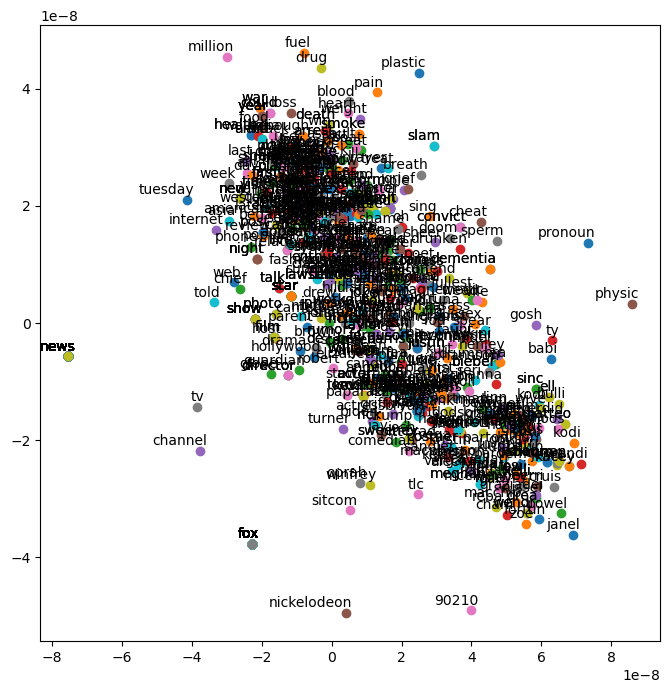

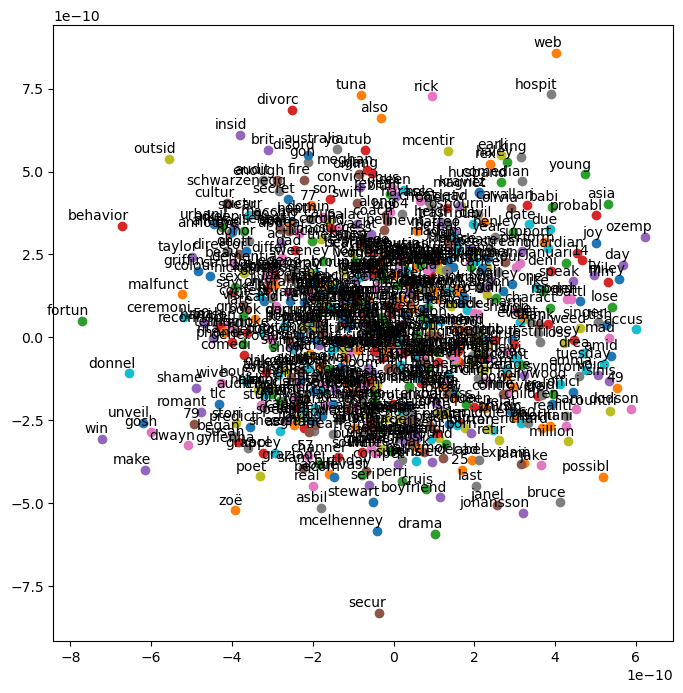

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
preprocessed_tokens = preprocess_text(text)
# Load GloVe embeddings
glove_embeddings = {}
with open("glove.6B.100d.txt", "r") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

# Train Word2Vec embeddings
model = Word2Vec([preprocessed_tokens], min_count=1, vector_size=100, workers=4)
def visualize_embeddings(embeddings, words):
    tsne = TSNE(n_components=2, random_state=0, perplexity=len(words)-1)
    embedding_vectors = np.array([embeddings[word] for word in words])
    two_d_embeddings = tsne.fit_transform(embedding_vectors)

    plt.figure(figsize=(8, 8))
    for i, word in enumerate(words):
        x, y = two_d_embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

# For GloVe
glove_words = [word for word in preprocessed_tokens if word in glove_embeddings]
visualize_embeddings(glove_embeddings, glove_words)

# For Word2Vec
word2vec_words = model.wv.index_to_key
visualize_embeddings(model.wv, word2vec_words)

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def find_related_words(embeddings, keyword, top_n=10):
    if keyword not in embeddings:
        return []

    # Get the vector for the keyword from embeddings
    keyword_vector = embeddings[keyword].reshape(1, -1)

    # Calculate cosine similarity between the keyword and all other vectors
    all_words = list(embeddings.keys())
    all_vectors = np.array(list(embeddings.values()))
    similarity_scores = cosine_similarity(keyword_vector, all_vectors).flatten()

    # Get indices of the top_n most similar words, excluding the first one (the word itself)
    most_similar_indices = similarity_scores.argsort()[-(top_n+1):][::-1][1:]

    # Return the top_n related words
    return [all_words[i] for i in most_similar_indices]


In [9]:
def visualize_embeddings(embeddings, words, model_type='glove'):
    tsne = TSNE(n_components=2, random_state=0, perplexity=max(5, len(words)-1))
    embedding_vectors = []
    for word in words:
        try:
            if model_type == 'glove':
                embedding_vectors.append(embeddings[word])
            elif model_type == 'word2vec':
                embedding_vectors.append(embeddings.get_vector(word))
        except KeyError:
            continue  # Skip words not in the model's vocabulary

    if not embedding_vectors:
        print("No vectors found for visualization.")
        return

    embedding_vectors = np.array(embedding_vectors)
    two_d_embeddings = tsne.fit_transform(embedding_vectors)

    plt.figure(figsize=(8, 8))
    for i, word in enumerate(words):
        if i < len(two_d_embeddings):  # Check to avoid IndexError
            x, y = two_d_embeddings[i, :]
            plt.scatter(x, y)
            plt.annotate(word, (x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()


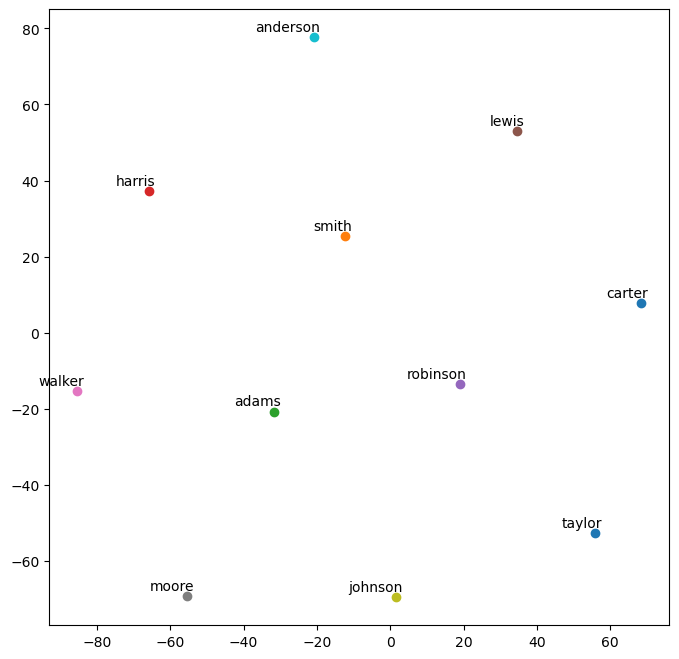

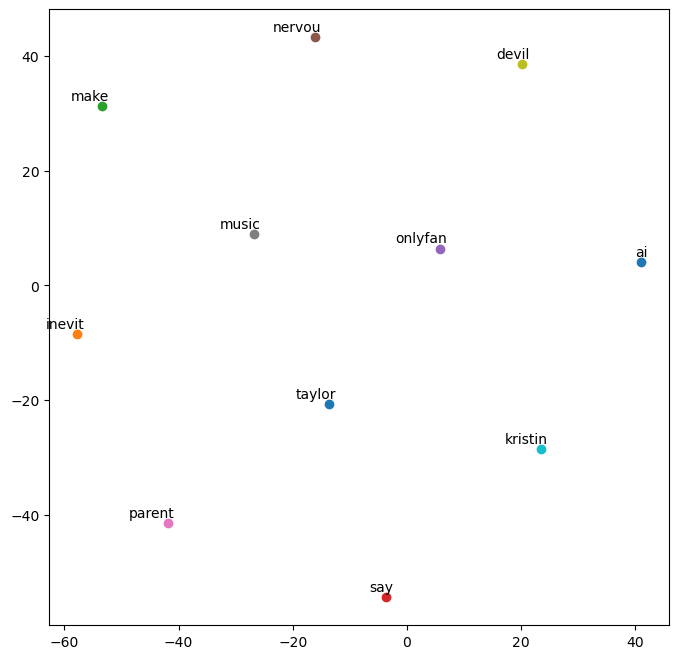

In [15]:
# Choose a keyword
keyword = 'taylor'  # Example keyword

# Find related words in GloVe
related_glove_words = find_related_words(glove_embeddings, keyword)
# Visualize keyword and its related words using GloVe embeddings
visualize_embeddings(glove_embeddings, [keyword] + related_glove_words, model_type='glove')

# For Word2Vec, ensure your keyword and its related are in the vocabulary
if keyword in model.wv:
    related_word2vec_words = find_related_words({word: model.wv[word] for word in model.wv.index_to_key}, keyword)
    # Visualize keyword and its related words using Word2Vec embeddings
    visualize_embeddings(model.wv, [keyword] + related_word2vec_words, model_type='word2vec')
else:
    print(f"'{keyword}' not found in Word2Vec model's vocabulary.")
